# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [2]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 48 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm as lgb
import catboost

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [4]:
df = df.drop(columns=['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'])

In [5]:
df.drop(df[df['Model'].isna()].index, inplace=True)

In [6]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


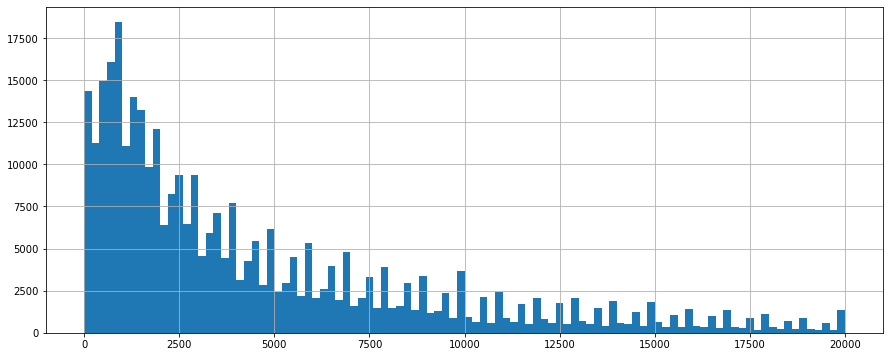

In [7]:
df.Price.hist(bins=100,figsize=(15,6));

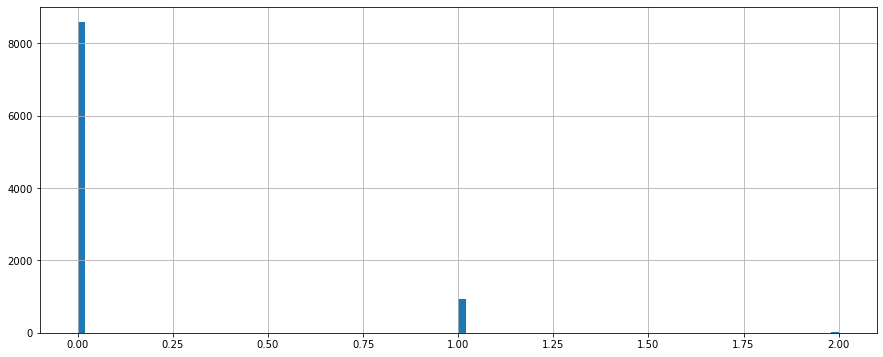

In [8]:
df.Price.hist(bins=100,figsize=(15,6),range=(0,2));

In [9]:
print('Доля машин с ценой меньше 100 евро:',(df[df['Price']<100].shape[0])/(df.shape[0]))

Доля машин с ценой меньше 100 евро: 0.03179905815982598


In [10]:
df = df[df['Price']>=100]

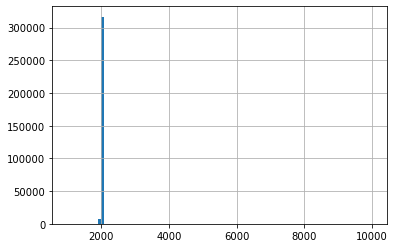

In [11]:
df.RegistrationYear.hist(bins=100);

In [12]:
df.RegistrationYear.sort_values().unique()

array([1000, 1001, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1941, 1942, 1943, 1945, 1947, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2066, 2200, 2290, 2500, 2900, 3000, 3700, 4000, 4500, 5000, 5555,
       5900, 5911, 6000, 7000, 7100, 7800, 8200, 8500, 9000, 9999],
      dtype=int64)

In [13]:
print('Доля машин выпущенных до 1980-го года:',(df[df['RegistrationYear']<1980].shape[0])/(df.shape[0]))

Доля машин выпущенных до 1980-го года: 0.0072525939596694055


In [14]:
df=df[df['RegistrationYear']>=1980]
df=df[df['RegistrationYear']<2066]

In [15]:
df.RegistrationYear.sort_values().unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

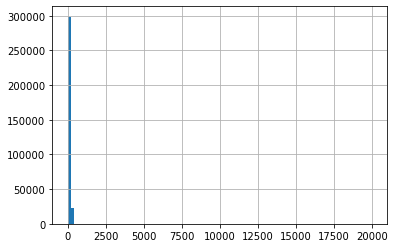

In [16]:
df.Power.hist(bins=100);

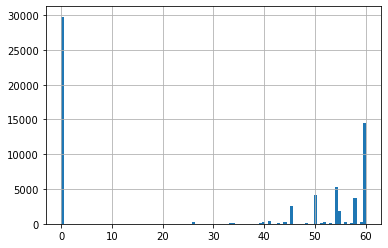

In [17]:
df.Power.hist(bins=100,range=(0,60));

In [18]:
(df[df['Power']<10].shape[0])/(df.shape[0])

0.09271580832514582

Машин с нулевой мощностью около 10 процентов, выкинуть не получится, восстановим по существующим данным(будем находить машины того же года и модели).

In [19]:
df.reset_index(drop= True , inplace= True )

In [20]:
df_power = df[df['Power']!=0]
df_power

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
5,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...
321622,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
321623,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
321625,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
321626,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [21]:
power={}
for model in df_power['Model'].unique():
    for year in df_power.loc[df_power['Model']==model,'RegistrationYear'].unique():
        power[model,year] = df_power.query(f"('{model}' in Model)&({year} == RegistrationYear)")['Power'].values[0]

In [22]:
power

{('grand', 2004): 163,
 ('grand', 2007): 129,
 ('grand', 1995): 211,
 ('grand', 2003): 163,
 ('grand', 2011): 129,
 ('grand', 2001): 174,
 ('grand', 2000): 223,
 ('grand', 2014): 250,
 ('grand', 2002): 173,
 ('grand', 2005): 109,
 ('grand', 2008): 218,
 ('grand', 1998): 212,
 ('grand', 2009): 426,
 ('grand', 1996): 177,
 ('grand', 2006): 106,
 ('grand', 2010): 166,
 ('grand', 2016): 223,
 ('grand', 1999): 220,
 ('grand', 2012): 129,
 ('grand', 1994): 190,
 ('grand', 1997): 212,
 ('grand', 1993): 80,
 ('grand', 2018): 150,
 ('grand', 1990): 80,
 ('grand', 2013): 169,
 ('grand', 2017): 220,
 ('golf', 2001): 75,
 ('golf', 1998): 101,
 ('golf', 2016): 75,
 ('golf', 2017): 80,
 ('golf', 2006): 105,
 ('golf', 2000): 90,
 ('golf', 2002): 265,
 ('golf', 1990): 54,
 ('golf', 2005): 90,
 ('golf', 1996): 75,
 ('golf', 1989): 69,
 ('golf', 1997): 75,
 ('golf', 1999): 90,
 ('golf', 2010): 80,
 ('golf', 1994): 75,
 ('golf', 1991): 98,
 ('golf', 2004): 75,
 ('golf', 2011): 170,
 ('golf', 2012): 211,


In [23]:
(df[df['Power']==0].shape[0])/(df.shape[0])

0.09255724004128994

In [24]:
def power_filler(data):
    for index in range(data[data['Power']==0].shape[0]):
        try:
            year = data.loc[index,:]['RegistrationYear']
            model = data.loc[index,:]['Model']
            data.loc[index,'Power'] = power[model,year]
        except KeyError:
            pass

In [25]:
power_filler(df)

In [26]:
(df[df['Power']==0].shape[0])/(df.shape[0])

0.0836090141405599

Данные которые не удалось восстановить по имеющимся, убираем.

In [27]:
df = df[df['Power']!=0]

In [28]:
df.reset_index(drop= True , inplace= True )

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294737 entries, 0 to 294736
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             294737 non-null  int64 
 1   VehicleType       275585 non-null  object
 2   RegistrationYear  294737 non-null  int64 
 3   Gearbox           288881 non-null  object
 4   Power             294737 non-null  int64 
 5   Model             294737 non-null  object
 6   Kilometer         294737 non-null  int64 
 7   FuelType          278003 non-null  object
 8   Brand             294737 non-null  object
 9   Repaired          251176 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


In [30]:
df.isna().sum()/df.isna().count()

Price               0.000000
VehicleType         0.064980
RegistrationYear    0.000000
Gearbox             0.019869
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.056776
Brand               0.000000
Repaired            0.147796
dtype: float64

In [31]:
models = df.Model.unique()

In [32]:
table={}
most_common={}
for model in models:
    for gearbox in ['auto','manual']:
        table[model,gearbox] = (df[df['Model']==model]['Gearbox']==gearbox).sum()
    if table[model,'auto'] > table[model,'manual']:
        most_common[model]='auto'
    else:
        most_common[model]='manual'
        

In [33]:
table

{('golf', 'auto'): 2795,
 ('golf', 'manual'): 22763,
 ('grand', 'auto'): 322,
 ('grand', 'manual'): 201,
 ('fabia', 'auto'): 97,
 ('fabia', 'manual'): 1826,
 ('3er', 'auto'): 3528,
 ('3er', 'manual'): 14098,
 ('2_reihe', 'auto'): 144,
 ('2_reihe', 'manual'): 4264,
 ('c_max', 'auto'): 48,
 ('c_max', 'manual'): 591,
 ('3_reihe', 'auto'): 198,
 ('3_reihe', 'manual'): 2885,
 ('passat', 'auto'): 2086,
 ('passat', 'manual'): 6835,
 ('navara', 'auto'): 16,
 ('navara', 'manual'): 66,
 ('polo', 'auto'): 437,
 ('polo', 'manual'): 10532,
 ('twingo', 'auto'): 165,
 ('twingo', 'manual'): 3670,
 ('a_klasse', 'auto'): 865,
 ('a_klasse', 'manual'): 2639,
 ('scirocco', 'auto'): 102,
 ('scirocco', 'manual'): 444,
 ('5er', 'auto'): 4001,
 ('5er', 'manual'): 3152,
 ('meriva', 'auto'): 87,
 ('meriva', 'manual'): 859,
 ('arosa', 'auto'): 19,
 ('arosa', 'manual'): 725,
 ('other', 'auto'): 4381,
 ('other', 'manual'): 15231,
 ('c4', 'auto'): 104,
 ('c4', 'manual'): 304,
 ('civic', 'auto'): 68,
 ('civic', 'manu

In [34]:
most_common

{'golf': 'manual',
 'grand': 'auto',
 'fabia': 'manual',
 '3er': 'manual',
 '2_reihe': 'manual',
 'c_max': 'manual',
 '3_reihe': 'manual',
 'passat': 'manual',
 'navara': 'manual',
 'polo': 'manual',
 'twingo': 'manual',
 'a_klasse': 'manual',
 'scirocco': 'manual',
 '5er': 'auto',
 'meriva': 'manual',
 'arosa': 'manual',
 'other': 'manual',
 'c4': 'manual',
 'civic': 'manual',
 'transporter': 'manual',
 'punto': 'manual',
 'e_klasse': 'auto',
 'clio': 'manual',
 'kadett': 'manual',
 'kangoo': 'manual',
 'one': 'manual',
 'fortwo': 'auto',
 '1er': 'manual',
 'b_klasse': 'manual',
 'signum': 'manual',
 'astra': 'manual',
 'a8': 'auto',
 'jetta': 'manual',
 'fiesta': 'manual',
 'c_klasse': 'manual',
 'micra': 'manual',
 'vito': 'manual',
 'sprinter': 'manual',
 '156': 'manual',
 'escort': 'manual',
 'forester': 'manual',
 'xc_reihe': 'auto',
 'scenic': 'manual',
 'a4': 'manual',
 'ka': 'manual',
 'a1': 'manual',
 'insignia': 'manual',
 'combo': 'manual',
 'focus': 'manual',
 'tt': 'manua

In [35]:
def gearbox_filler(data):
    for model in data['Model'].unique():
        df.loc[df['Model']==model,'Gearbox'] = df.loc[df['Model']==model,'Gearbox'].fillna(value=most_common[model])

In [36]:
gearbox_filler(df)

In [37]:
df.isna().sum()/df.isna().count()

Price               0.000000
VehicleType         0.064980
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.056776
Brand               0.000000
Repaired            0.147796
dtype: float64

Пропуски в колонке Repaired будем считать за отсутствие ремонта.

In [38]:
df['Repaired'] = df['Repaired'].fillna(value='no')

In [39]:
df.loc[df['Repaired']=='yes','Repaired'] = 1
df.loc[df['Repaired']=='no','Repaired'] = 0

In [40]:
df['Repaired'].unique()

array([0, 1], dtype=object)

In [41]:
df.isna().sum()/df.isna().count()

Price               0.000000
VehicleType         0.064980
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.056776
Brand               0.000000
Repaired            0.000000
dtype: float64

In [42]:
df['Power'].sort_values().unique()

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,
          19,    20,    21,    22,    23,    24,    25,    26,    27,
          28,    29,    30,    31,    32,    33,    34,    35,    36,
          37,    38,    39,    40,    41,    42,    43,    44,    45,
          46,    47,    48,    49,    50,    51,    52,    53,    54,
          55,    56,    57,    58,    59,    60,    61,    62,    63,
          64,    65,    66,    67,    68,    69,    70,    71,    72,
          73,    74,    75,    76,    77,    78,    79,    80,    81,
          82,    83,    84,    85,    86,    87,    88,    89,    90,
          91,    92,    93,    94,    95,    96,    97,    98,    99,
         100,   101,   102,   103,   104,   105,   106,   107,   108,
         109,   110,   111,   112,   113,   114,   115,   116,   117,
         118,   119,   120,   121,   122,   123,   124,   125,   126,
         127,   128,

In [43]:
print('Доля автомобилей с мощностью менее 20 л.с.:',df[df['Power']<20].shape[0]/df.shape[0])
print('Доля автомобилей с мощностью более 1000 л.с:',df[df['Power']>1000].shape[0]/df.shape[0])

Доля автомобилей с мощностью менее 20 л.с.: 0.0003698212304529123
Доля автомобилей с мощностью более 1000 л.с: 0.0008074995674109461


In [44]:
df = df[(df['Power']>20)&(df['Power']<1000)]

In [45]:
df.reset_index(inplace=True,drop=True)

In [46]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,90,golf,150000,petrol,volkswagen,0
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,1
...,...,...,...,...,...,...,...,...,...,...
294378,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,0
294379,3200,sedan,2004,manual,225,leon,150000,petrol,seat,1
294380,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,0
294381,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,0


In [47]:
df.isna().sum()/df.isna().count()

Price               0.000000
VehicleType         0.064905
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.056644
Brand               0.000000
Repaired            0.000000
dtype: float64

In [48]:
fuel={}
for model in models:
    for power in df.loc[df['Model']==model,'Power'].unique():
        data = df.loc[(df['Power']==power)&(df['Model']==model)]
        fuel_n=[]
        fuel_t=[]
        best_score=0
        for f_type in data['FuelType'].unique():
            fuel_n = data[data['FuelType']==f_type].shape[0]
            fuel_t = f_type
            if best_score < fuel_n:
                best_score = fuel_n
                best_fuel = fuel_t            
        fuel[model,power] = best_fuel

In [49]:
fuel

{('golf', 90): 'petrol',
 ('golf', 75): 'petrol',
 ('golf', 101): 'petrol',
 ('golf', 80): 'petrol',
 ('golf', 105): 'gasoline',
 ('golf', 265): 'petrol',
 ('golf', 54): 'petrol',
 ('golf', 69): 'petrol',
 ('golf', 98): 'petrol',
 ('golf', 170): 'gasoline',
 ('golf', 211): 'petrol',
 ('golf', 66): 'petrol',
 ('golf', 140): 'gasoline',
 ('golf', 86): 'petrol',
 ('golf', 55): 'petrol',
 ('golf', 150): 'petrol',
 ('golf', 111): 'petrol',
 ('golf', 60): 'petrol',
 ('golf', 179): 'petrol',
 ('golf', 116): 'petrol',
 ('golf', 139): 'petrol',
 ('golf', 125): 'petrol',
 ('golf', 104): 'petrol',
 ('golf', 110): 'gasoline',
 ('golf', 102): 'petrol',
 ('golf', 100): 'petrol',
 ('golf', 115): 'petrol',
 ('golf', 70): 'petrol',
 ('golf', 200): 'petrol',
 ('golf', 230): 'petrol',
 ('golf', 246): 'petrol',
 ('golf', 96): 'petrol',
 ('golf', 174): 'petrol',
 ('golf', 122): 'petrol',
 ('golf', 176): 'petrol',
 ('golf', 72): 'petrol',
 ('golf', 120): 'petrol',
 ('golf', 205): 'petrol',
 ('golf', 131): '

In [50]:
def fuel_filler(data):
    for model in data['Model'].unique():
        df_model = data[data['Model']==model]
        for power in df_model['Power'].unique():
            df.loc[df['Model']==model,'FuelType'] = df.loc[df['Model']==model,'FuelType'].fillna(value=fuel[model,power])

In [51]:
fuel_filler(df)

In [52]:
df.isna().sum()/df.isna().count()

Price               0.000000
VehicleType         0.064905
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.000000
Brand               0.000000
Repaired            0.000000
dtype: float64

In [53]:
vehicle={}
for model in models:
    for power in df.loc[df['Model']==model,'Power'].unique():
        data = df.loc[(df['Power']==power)&(df['Model']==model)]
        vehicle_n=[]
        vehicle_t=[]
        best_score=0
        for v_type in data['VehicleType'].unique():
            vehicle_n = data[data['VehicleType']==v_type].shape[0]
            vehicle_t = v_type
            if best_score < vehicle_n:
                best_score = vehicle_n
                best_vehicle = vehicle_t            
        vehicle[model,power] = best_vehicle


In [54]:
vehicle

{('golf', 90): 'sedan',
 ('golf', 75): 'sedan',
 ('golf', 101): 'sedan',
 ('golf', 80): 'sedan',
 ('golf', 105): 'sedan',
 ('golf', 265): 'sedan',
 ('golf', 54): 'sedan',
 ('golf', 69): 'sedan',
 ('golf', 98): 'convertible',
 ('golf', 170): 'sedan',
 ('golf', 211): 'sedan',
 ('golf', 66): 'small',
 ('golf', 140): 'sedan',
 ('golf', 86): 'sedan',
 ('golf', 55): 'small',
 ('golf', 150): 'sedan',
 ('golf', 111): 'sedan',
 ('golf', 60): 'sedan',
 ('golf', 179): 'sedan',
 ('golf', 116): 'sedan',
 ('golf', 139): 'sedan',
 ('golf', 125): 'sedan',
 ('golf', 104): 'sedan',
 ('golf', 110): 'sedan',
 ('golf', 102): 'sedan',
 ('golf', 100): 'sedan',
 ('golf', 115): 'sedan',
 ('golf', 70): 'small',
 ('golf', 200): 'sedan',
 ('golf', 230): 'sedan',
 ('golf', 246): 'sedan',
 ('golf', 96): 'convertible',
 ('golf', 174): 'sedan',
 ('golf', 122): 'sedan',
 ('golf', 176): 'small',
 ('golf', 72): 'sedan',
 ('golf', 120): 'sedan',
 ('golf', 205): 'sedan',
 ('golf', 131): 'sedan',
 ('golf', 160): 'sedan',
 

In [55]:
def vehicle_filler(data):
    for model in data['Model'].unique():
        df_model = data[data['Model']==model]
        for power in df_model['Power'].unique():
            df.loc[df['Model']==model,'VehicleType'] = df.loc[df['Model']==model,'VehicleType'].fillna(value=vehicle[model,power])

In [56]:
vehicle_filler(df)

In [57]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,90,golf,150000,petrol,volkswagen,0
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,1
...,...,...,...,...,...,...,...,...,...,...
294378,5250,wagon,2016,auto,150,159,150000,petrol,alfa_romeo,0
294379,3200,sedan,2004,manual,225,leon,150000,petrol,seat,1
294380,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,0
294381,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,0


In [58]:
df.isna().sum()/df.isna().count()

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
dtype: float64

Общий вывод: 
1. Пропуски в колонке модель были удалены, т.к. по имеющимся данным их сложно восстановить
2. Аномальные значения в колонках были удалены
3. Пропуски в остальных колонках были восстановлены по имеющимся данным
4. Колонки ['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'] посчитал не информативными к формированию цены автомобиля, убрал их

## Обучение моделей

Разделим датасет на признаки и цель, закодируем и отмасшатибируем данные.

In [59]:
df['Repaired'] = df['Repaired'].astype(int)

In [60]:
features = df.drop(columns=['Price','Brand'])
target = df['Price']

In [61]:
X_train, X_other, y_train, y_other = train_test_split(features, target, test_size=0.3, random_state=12345)

In [62]:
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=12345)

In [63]:
encoder = OrdinalEncoder()
cat_columns = ['Model','VehicleType','FuelType','Gearbox']
encoder.fit(X_train[cat_columns])

features_train_ord = X_train.copy()
features_valid_ord = X_valid.copy()
features_test_ord = X_test.copy()

X_train[cat_columns] = encoder.transform(features_train_ord[cat_columns])
X_valid[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
X_test[cat_columns] = encoder.transform(features_test_ord[cat_columns])

```python
# порядковое кодирование
encoder = OrdinalEncoder()
cat_columns = [список всех категориальных признаков]
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
```

LGBMRegressor()

In [64]:
train_data = lgb.Dataset(X_train,label=y_train)
valid_data = lgb.Dataset(X_valid,label=y_valid)
test_data = lgb.Dataset(X_test,label=y_test)

In [65]:
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [5,15],
             }

lgbm = lgb.LGBMRegressor()

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                         'max_depth': [5, 15]},
             scoring='neg_mean_squared_error')

In [66]:
print(grid_search.best_params_)

{'learning_rate': 0.5, 'max_depth': 15}


In [67]:
print('RMSE:',(abs(grid_search.best_score_))**0.5)

RMSE: 1676.9970638602153


In [68]:
model = lgb.LGBMRegressor(learning_rate=0.5,max_depth=15)

In [69]:
%%time
model.fit(X_train,y_train)

CPU times: total: 3.64 s
Wall time: 314 ms


LGBMRegressor(learning_rate=0.5, max_depth=15)

In [70]:
predict = model.predict(X_valid)

In [71]:
mean_squared_error(predict,y_valid)**0.5

1651.9294599323332

CatBoostRegressor()

In [72]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [5,15],
             }

cat = catboost.CatBoostRegressor(verbose=False,iterations=100)

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = cat, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002026A29CAC0>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 15]},
             scoring='neg_mean_squared_error')

In [73]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 15}


In [74]:
print('RMSE:',(abs(grid_search.best_score_))**0.5)

RMSE: 1719.9899107885435


In [75]:
cat = catboost.CatBoostRegressor(learning_rate = 0.1, max_depth = 15,verbose=False, iterations = 100)

In [76]:
%%time
cat.fit(X_train,y_train);

CPU times: total: 37.1 s
Wall time: 31.9 s


In [77]:
predict = cat.predict(X_valid)

In [78]:
mean_squared_error(predict,y_valid)**0.5

1697.444724525254

LinearRegression()

In [79]:
lin = LinearRegression()

In [80]:
%%time
lin.fit(X_train,y_train)

CPU times: total: 15.6 ms
Wall time: 29.1 ms


LinearRegression()

In [81]:
predict = lin.predict(X_valid)

In [82]:
mean_squared_error(predict,y_valid)**0.5

2923.036004823045

Вывод: 
1. Данные были подготовлены для использования (закодированы и масштабированы) 
2. Было обучено 3 модели (LGBMRegressor,CatBoostRegressor,LinearRegression)
3. Были получены удовлетровительные метрики rmse (<2500)

## Анализ моделей

CatBoostRegressor с подобранным параметром iterations.

In [83]:
cat_it = catboost.CatBoostRegressor(learning_rate = 0.1, max_depth = 15,verbose=False,iterations = 150)

Сравнение времени обучения

In [84]:
%%time
lin.fit(X_train,y_train)

CPU times: total: 31.2 ms
Wall time: 21.4 ms


LinearRegression()

In [85]:
%%time
model.fit(X_train,y_train)

CPU times: total: 3.55 s
Wall time: 424 ms


LGBMRegressor(learning_rate=0.5, max_depth=15)

In [86]:
%%time
cat_it.fit(X_train,y_train)

CPU times: total: 53.8 s
Wall time: 48.1 s


Сравнение времени предсказания

In [87]:
%%time
l_predict = lin.predict(X_valid)

CPU times: total: 0 ns
Wall time: 0 ns


In [88]:
%%time
m_predict = model.predict(X_valid)

CPU times: total: 156 ms
Wall time: 26.7 ms


In [89]:
%%time
cat_pred = cat_it.predict(X_valid)

CPU times: total: 172 ms
Wall time: 27 ms


Сравнение качества моделей

In [90]:
print('RMSE LinearRegression:',mean_squared_error(l_predict,y_valid)**0.5)

RMSE LinearRegression: 2923.036004823045


In [91]:
print('RMSE LGBMRegressor:',mean_squared_error(m_predict,y_valid)**0.5)

RMSE LGBMRegressor: 1651.9294599323332


In [92]:
print('RMSE CatBoostRegressor iterations=150:',mean_squared_error(cat_pred,y_valid)**0.5)

RMSE CatBoostRegressor iterations=150: 1652.3117051447605


In [93]:
pd.DataFrame({'Model' : ['LinearRegression','LGBMRegressor','CatBoostRegressor'],'fit time':
             ['52.8 ms','25.5 s','1min 23s'],'predict time':['3.27 ms','203 ms','62.7 ms'],'RMSE':['2923','1651','1652']})

,Model,fit time,predict time,RMSE
0,LinearRegression,52.8 ms,3.27 ms,2923
1,LGBMRegressor,25.5 s,203 ms,1651
2,CatBoostRegressor,1min 23s,62.7 ms,1652


## Тестирование лучшей модели

In [94]:
lgmb_prediction = model.predict(X_test)
print('RMSE LGBMRegressor:',mean_squared_error(lgmb_prediction,y_test)**0.5)

RMSE LGBMRegressor: 1635.8501503275236


Вывод: Была выбрана модель LGBMRegressor, т.к. она имела преимущество в скорости обучения и хорошем качестве предсказаний. На тестовых данных модель также показала удовлетворительные результаты.

Вывод: 

Лучшие показатели:
1. Время обучения - LinearRegression
2. Время предсказания - LinearRegression
3. Качество предсказания - CatBoostRegressor

У модели LinearRegression быстрое обучение и предсказание, но плохое качество, а у CatBoostRegressor наоборот, медленное обучение и предсказание, зато лучшее качество(это во многом определяется параметром iterations).Модель LGBMRegressor имеет качество как у CatBoostRegressor, а также время обучение заметно ниже чем у catboost. Однако же, если подобрать параметр iterations, то можно убедиться в том, что catboost имеет хорошую скорость и качество. Модель LGBMRegressor можно считать лучшей.